In [1]:
!pip install pgmpy

In [2]:
import pandas as pd
from pgmpy.estimators import PC, HillClimbSearch,MmhcEstimator
import networkx as nx
from pgmpy.estimators import BicScore ,K2Score, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.models import BayesianNetwork
import numpy as np
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG
from pgmpy.metrics import correlation_score

# Order Variables

In [3]:
orderd_list = ['Age','Gender','Education','MaritalStatus','DistanceFromHome','WorkLifeBalance','TotalWorkingYears','JobLevel',
                'BusinessTravel','OverTime','PerformanceRating','JobSatisfaction','MonthlyIncome','Attrition']

 Estimates a DAG/PDAG from the given dataset using the PC algorithm which
        is a constraint-based structure learning algorithm[1]. The independencies
        in the dataset are identified by doing statistical independece test. This
        method returns a DAG/PDAG structure which is faithful to the independencies
        implied by the datase
The statistical tests use this value to compare with the p-value of the test to decide whether the tested variables are independent or not<br>
Types of test:
<li>
<ul> "chi_square": Uses the Chi-Square independence test. This works only for discrete datasets.
<ul> "pearsonr": Uses the pertial correlation based on pearson correlation coefficient to test independence. This works only for continuous datasets.
</li>

Working for n conditional variables: 4: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


DAG with 8 nodes and 7 edges


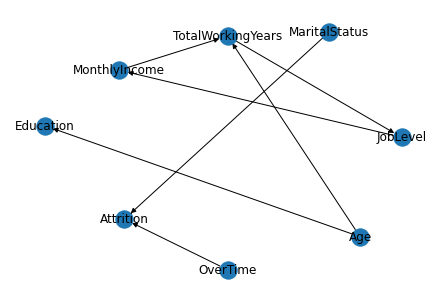

In [16]:
df = pd.read_csv("data/cleaning_dataset.csv")
pcest = PC(df)
pcmodel = pcest.estimate(variant = 'stable',max_cond_vars=4, significance_level=0.05)
print(pcmodel)
nx.draw(pcmodel, with_labels=True)

# Hill Climbing

  0%|          | 8/1000000 [00:02<104:06:33,  2.67it/s]


-16957.62954195102
8


0.8455284552845528

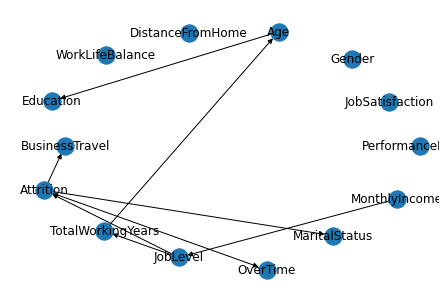

In [17]:
est = HillClimbSearch(df)
best_model = est.estimate(scoring_method=BicScore(df))
nx.draw(best_model, with_labels=True)
print(BicScore(df).score(best_model))
print(len(best_model.edges()))
correlation_score(best_model, df, test="chi_square", significance_level=0.05)

The K2 score is the result of setting all Dirichlet hyperparameters/pseudo_counts to 1.
The `score`-method measures how well a model is able to describe the given data set.

  0%|          | 10/1000000 [00:02<82:48:21,  3.35it/s]


-16919.66087345071
10


0.6730769230769229

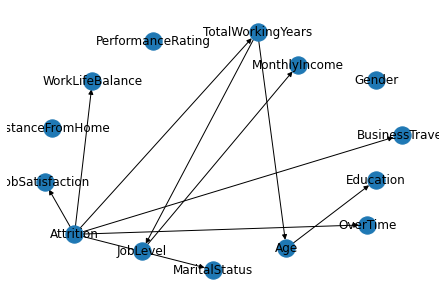

In [18]:
est = HillClimbSearch(df)
best_model = est.estimate(scoring_method=K2Score(df))
nx.draw(best_model, with_labels=True)
print(K2Score(df).score(best_model))
print(len(best_model.edges()))
correlation_score(best_model, df, test="chi_square", significance_level=0.05)

In [6]:
edges = [("DistanceFromHome","WorkLifeBalance"),
            ("MaritalStatus","WorkLifeBalance"),
            ("MaritalStatus","BusinessTravel"),
            ("Education","JobLevel"),
            ("WorkLifeBalance","JobSatisfaction"),
            ("WorkLifeBalance","PerformanceRating"),
            ("OverTime","Attrition"),
            ("JobLevel","MonthlyIncome"),
            ("PerformanceRating","MonthlyIncome"),
                ]
print(len(edges))

9


  0%|          | 4/1000000 [00:02<144:35:13,  1.92it/s]


13


0.5161290322580645

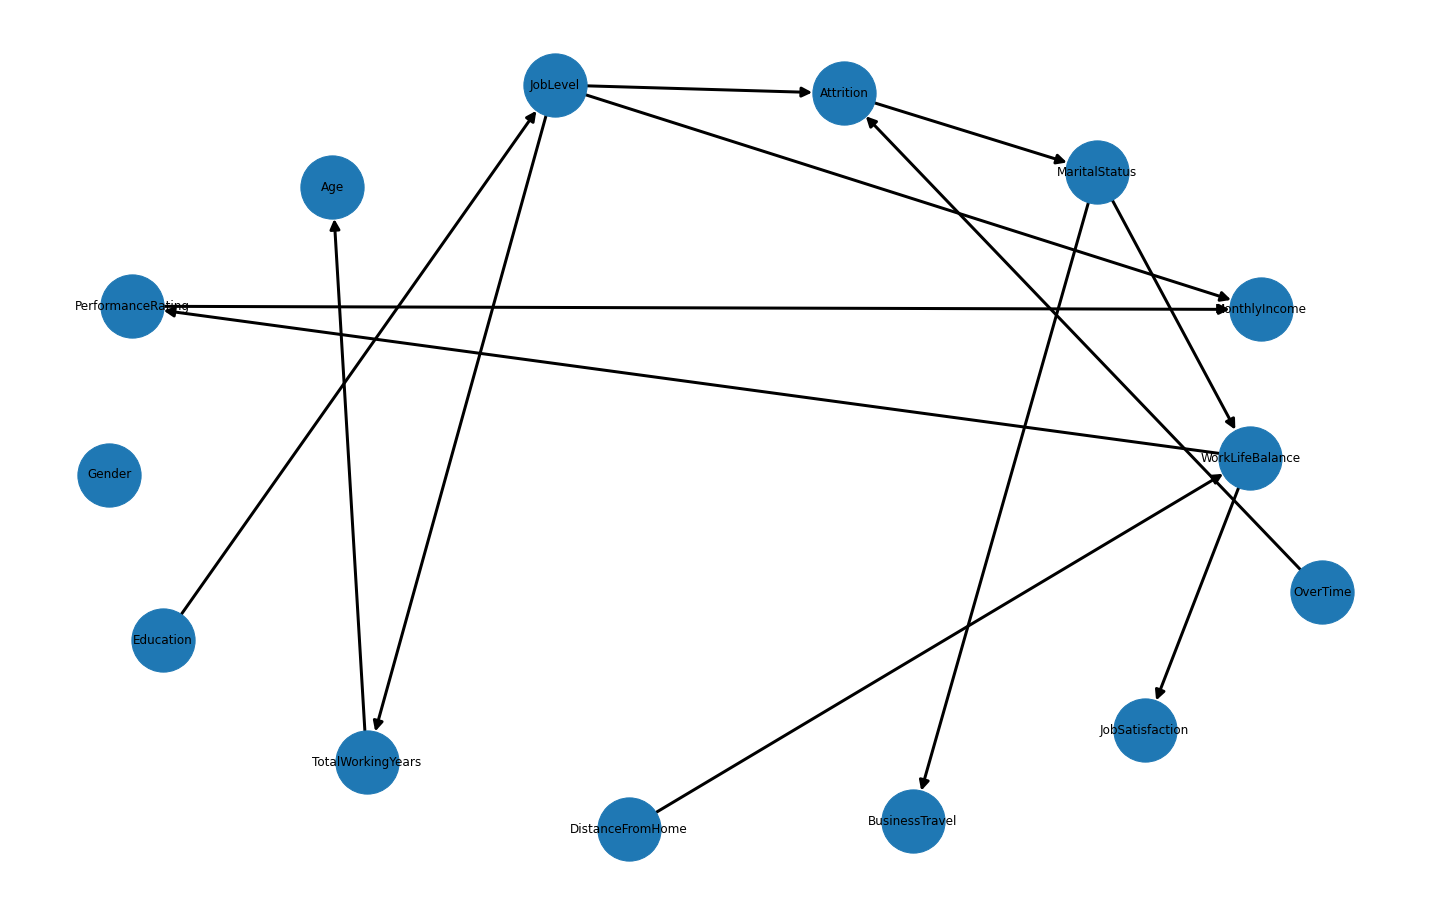

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
est = HillClimbSearch(df)
best_model = est.estimate(scoring_method=BicScore(df),fixed_edges= edges)
nx.draw(best_model, with_labels=True,node_size=4000, width=3, arrowsize=20)
print(len(best_model.edges()))
correlation_score(best_model, df, test="chi_square", significance_level=0.05)

  0%|          | 6/1000000 [00:05<247:21:33,  1.12it/s] 


15


0.449438202247191

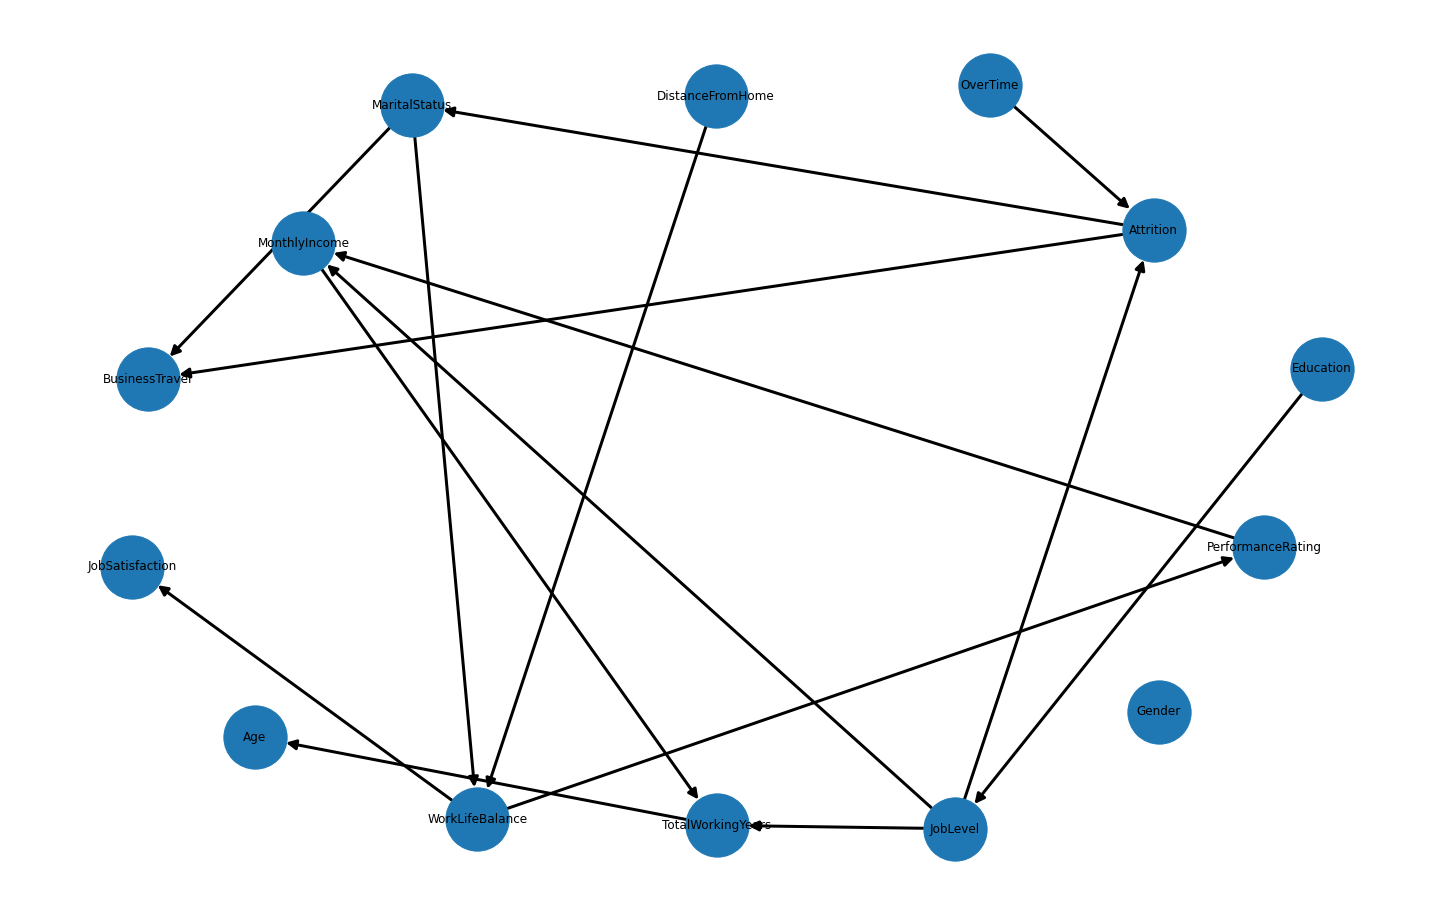

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
est = HillClimbSearch(df)
best_model = est.estimate(scoring_method=K2Score(df),fixed_edges= edges)
nx.draw(best_model, with_labels=True,node_size=4000, width=3, arrowsize=20)
print(len(best_model.edges()))
correlation_score(best_model, df, test="chi_square", significance_level=0.05)

# Using Ordered List and start Diag

In [11]:
# Using black list
black_list = []
for i in range(0,len(orderd_list)):
    for j in range(0,i):
        black_list.append((orderd_list[i],orderd_list[j]))

#print(black_list)

  0%|          | 4/1000000 [00:01<109:18:11,  2.54it/s]


13


0.7741935483870968

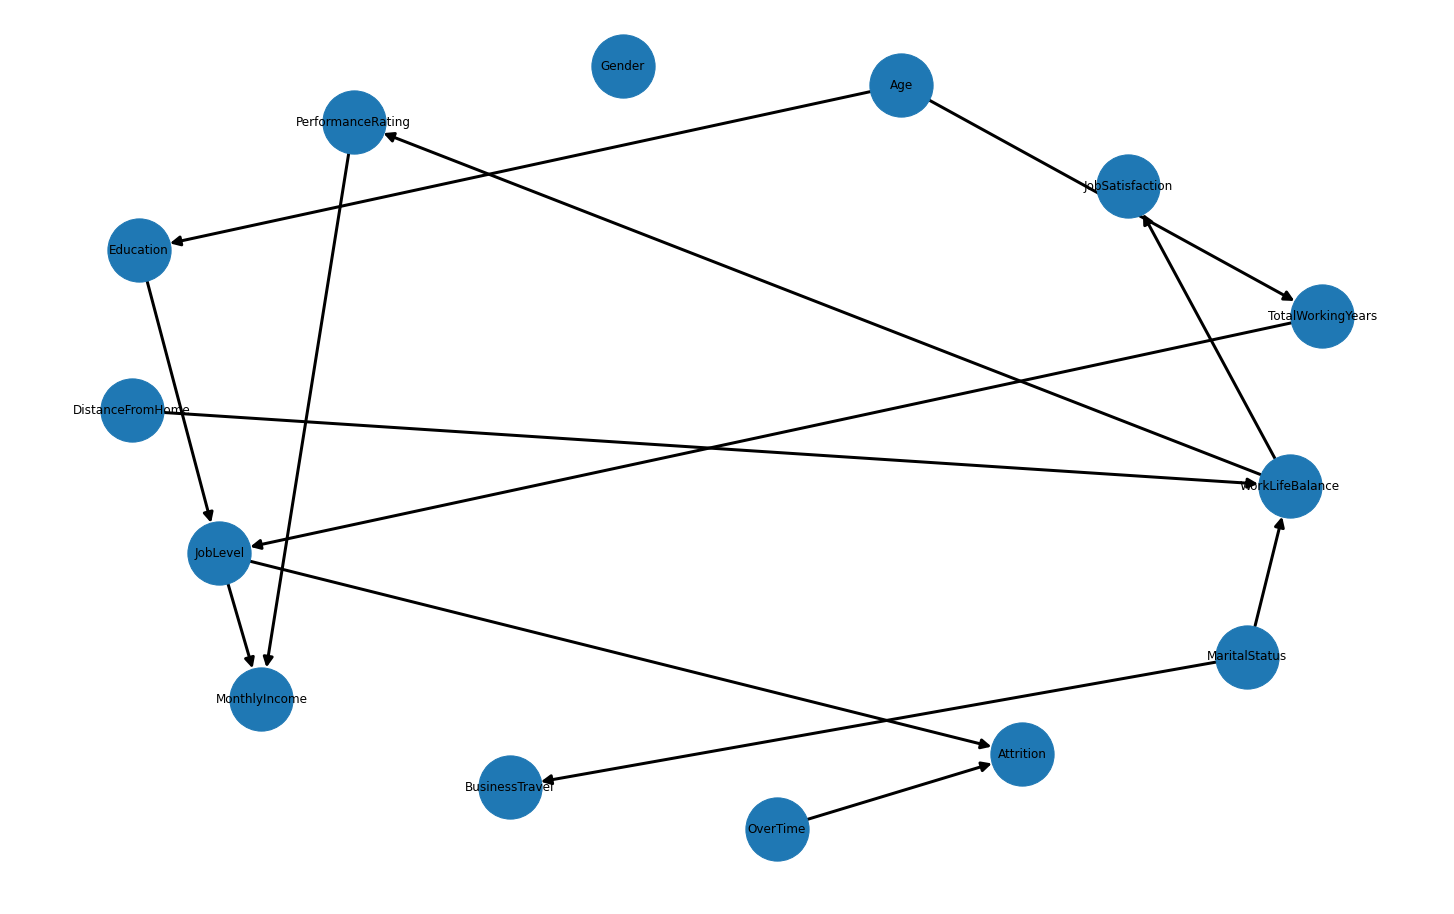

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
est = HillClimbSearch(df)
start_dag = DAG()
start_dag.add_edges_from(ebunch=edges)
best_model = est.estimate(scoring_method=BicScore(df),fixed_edges=edges, black_list=black_list)
nx.draw(best_model, with_labels=True,node_size=4000, width=3, arrowsize=20)
print(len(best_model.edges()))
correlation_score(best_model, df, test="chi_square", significance_level=0.05)

  0%|          | 0/1000000 [00:00<?, ?it/s]

DAG with 11 nodes and 9 edges


  0%|          | 4/1000000 [00:01<73:44:57,  3.77it/s] 


13


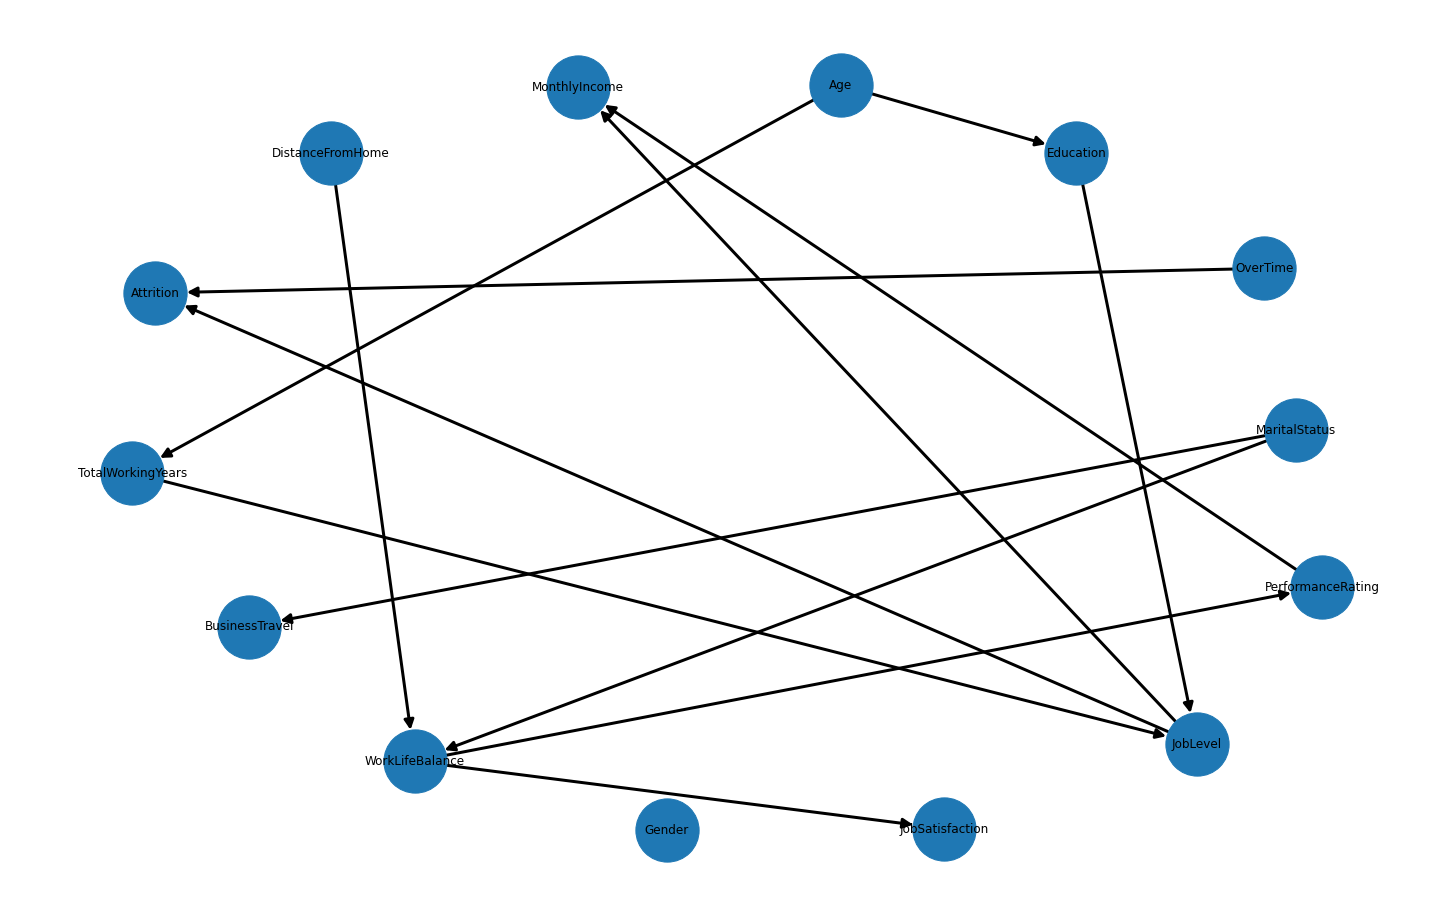

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12.5))
est = HillClimbSearch(df)
best_model = est.estimate(scoring_method=K2Score(df),fixed_edges=edges, black_list=black_list)
nx.draw(best_model, with_labels=True,node_size=4000, width=3, arrowsize=20)
print(len(best_model.edges()))

In [12]:

correlation_score(best_model, df, test="chi_square", significance_level=0.05)

0.7741935483870968